In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

from category_encoders import TargetEncoder

In [2]:
# Load dataset
NYtraffic = pd.read_csv('~/Data Science Labs/Project Datasets/NY Traffic Accidents/monroe-county-crash-data2003-to-2015.csv', encoding = 'latin1')

NYtraffic.rename({'Weekend?':'Weekend', 'Reported_Location':'Reported Location'}, axis = 1, inplace = True)

In [3]:
#Find Missing Values

def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(3)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

In [4]:
missing_zero_values_table(NYtraffic)

Your selected dataframe has 12 columns and 53943 Rows.
There are 7 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
Primary Factor,0,1121,2.078,1121,2.078,object
Hour,1115,225,0.417,1340,2.484,float64
Weekend,0,68,0.126,68,0.126,object
Reported Location,0,35,0.065,35,0.065,object
Latitude,4908,30,0.056,4938,9.154,float64
Longitude,4908,30,0.056,4938,9.154,float64
Collision Type,0,6,0.011,6,0.011,object


In [5]:
NYtraffic.head()

,Master Record Number,Year,Month,Day,Weekend,Hour,Collision Type,Injury Type,Primary Factor,Reported Location,Latitude,Longitude
0,902363382,2015,1,5,Weekday,0.0,2-Car,No injury/unknown,OTHER (DRIVER) - EXPLAIN IN NARRATIVE,1ST & FESS,39.159207,-86.525874
1,902364268,2015,1,6,Weekday,1500.0,2-Car,No injury/unknown,FOLLOWING TOO CLOSELY,2ND & COLLEGE,39.161440,-86.534848
2,902364412,2015,1,6,Weekend,2300.0,2-Car,Non-incapacitating,DISREGARD SIGNAL/REG SIGN,BASSWOOD & BLOOMFIELD,39.149780,-86.568890
3,902364551,2015,1,7,Weekend,900.0,2-Car,Non-incapacitating,FAILURE TO YIELD RIGHT OF WAY,GATES & JACOBS,39.165655,-86.575956
4,902364615,2015,1,7,Weekend,1100.0,2-Car,No injury/unknown,FAILURE TO YIELD RIGHT OF WAY,W 3RD,39.164848,-86.579625


In [6]:
NYtraffic_dropped = NYtraffic[['Year','Month','Day','Weekend','Hour','Collision Type','Injury Type']]

In [7]:
NYtraffic_dropped.head()

,Year,Month,Day,Weekend,Hour,Collision Type,Injury Type
0,2015,1,5,Weekday,0.0,2-Car,No injury/unknown
1,2015,1,6,Weekday,1500.0,2-Car,No injury/unknown
2,2015,1,6,Weekend,2300.0,2-Car,Non-incapacitating
3,2015,1,7,Weekend,900.0,2-Car,Non-incapacitating
4,2015,1,7,Weekend,1100.0,2-Car,No injury/unknown


In [8]:
NYtraffic_dropped.isnull().sum()

Year                0
Month               0
Day                 0
Weekend            68
Hour              225
Collision Type      6
Injury Type         0
dtype: int64

In [9]:
NYtraffic_dropped = NYtraffic_dropped.drop(NYtraffic_dropped[NYtraffic_dropped['Hour'].isnull()].index)
NYtraffic_dropped.isnull().sum()

Year              0
Month             0
Day               0
Weekend           0
Hour              0
Collision Type    6
Injury Type       0
dtype: int64

In [10]:
NYtraffic_dropped = NYtraffic_dropped.drop(NYtraffic_dropped[NYtraffic_dropped['Collision Type'].isnull()].index)

In [11]:
NYtraffic_dropped.isnull().sum()

Year              0
Month             0
Day               0
Weekend           0
Hour              0
Collision Type    0
Injury Type       0
dtype: int64

In [12]:
NYtraffic_dropped.head()

,Year,Month,Day,Weekend,Hour,Collision Type,Injury Type
0,2015,1,5,Weekday,0.0,2-Car,No injury/unknown
1,2015,1,6,Weekday,1500.0,2-Car,No injury/unknown
2,2015,1,6,Weekend,2300.0,2-Car,Non-incapacitating
3,2015,1,7,Weekend,900.0,2-Car,Non-incapacitating
4,2015,1,7,Weekend,1100.0,2-Car,No injury/unknown


In [13]:
# Convert Hour column to 3 categories, Peak Hour, Off-Peak Day, Off-Peak Night
# 1: Peak Hour is 6am-9:59am and 3pm - 6:59pm
# 2: Off-Peak Day is 10am - 2:59pm
# 3: Off-Peak Night is 7pm - 5:59am

def create_peak_class(x):
    
    if ((x >= 600.0) & (x < 1000.0)) | ((x >= 1500.0) & (x < 1900.0)):
        peak_class = 1

    elif (x >= 1000.0) & (x < 1500.0):
        peak_class = 2
        
    else:
        peak_class = 3
        
    return peak_class

In [14]:
peak_class = []
for i in NYtraffic_dropped.Hour:
    peak_class.append(create_peak_class(i))

NYtraffic_dropped['Peak Hour Class'] = peak_class
NYtraffic_dropped.head()

,Year,Month,Day,Weekend,Hour,Collision Type,Injury Type,Peak Hour Class
0,2015,1,5,Weekday,0.0,2-Car,No injury/unknown,3
1,2015,1,6,Weekday,1500.0,2-Car,No injury/unknown,1
2,2015,1,6,Weekend,2300.0,2-Car,Non-incapacitating,3
3,2015,1,7,Weekend,900.0,2-Car,Non-incapacitating,1
4,2015,1,7,Weekend,1100.0,2-Car,No injury/unknown,2


In [15]:
# Rename Injury Type to Ordinal variables
# 0: No Injury/unknown
# 1: Non-incapacitating
# 2: Incapacitating
# 3: Fatal

def create_injury_class(x):
    if x == 'No injury/unknown':
        injury_class = 0
    elif x == 'Non-incapacitating':
        injury_class = 1
    elif x == 'Incapacitating':
        injury_class = 2
    else:
        injury_class = 3
    return injury_class

In [16]:
injury_class = []
for i in NYtraffic_dropped['Injury Type']:
    injury_class.append(create_injury_class(i))

NYtraffic_dropped['Injury Class'] = injury_class

In [17]:
# Convert Injury Type to No Injury = 0 and Injury = 1, regardless whether it's incapacitating or not

def create_injury_binary(x):
    if x == 'No injury/unknown':
        injury_binary = 0
    else:
        injury_binary = 1
    return injury_binary

injury_binary = []
for i in NYtraffic_dropped['Injury Type']:
    injury_binary.append(create_injury_binary(i))

NYtraffic_dropped['Injury Binary'] = injury_binary

NYtraffic_dropped.sample(20)

,Year,Month,Day,Weekend,Hour,Collision Type,Injury Type,Peak Hour Class,Injury Class,Injury Binary
20977,2010,11,3,Weekday,1700.0,3+ Cars,Non-incapacitating,1,1,1
28995,2008,12,3,Weekday,800.0,Bus,No injury/unknown,1,0,0
44224,2005,1,4,Weekday,300.0,1-Car,No injury/unknown,3,0,0
29305,2008,7,2,Weekday,1600.0,2-Car,No injury/unknown,1,0,0
9106,2013,9,3,Weekday,1300.0,2-Car,No injury/unknown,2,0,0
19416,2011,9,2,Weekday,1900.0,1-Car,No injury/unknown,3,0,0
3617,2015,11,3,Weekday,800.0,2-Car,No injury/unknown,1,0,0
12633,2012,10,3,Weekday,1700.0,2-Car,No injury/unknown,1,0,0
21865,2010,12,6,Weekday,1600.0,2-Car,No injury/unknown,1,0,0
53067,2003,1,3,Weekday,1500.0,2-Car,No injury/unknown,1,0,0


In [18]:
NYtraffic_dropped = pd.get_dummies(data = NYtraffic_dropped, columns = ['Weekend'])

NYtraffic_dropped

,Year,Month,Day,Hour,Collision Type,Injury Type,Peak Hour Class,Injury Class,Injury Binary,Weekend_Weekday,Weekend_Weekend
0,2015,1,5,0.0,2-Car,No injury/unknown,3,0,0,1,0
1,2015,1,6,1500.0,2-Car,No injury/unknown,1,0,0,1,0
2,2015,1,6,2300.0,2-Car,Non-incapacitating,3,1,1,0,1
3,2015,1,7,900.0,2-Car,Non-incapacitating,1,1,1,0,1
4,2015,1,7,1100.0,2-Car,No injury/unknown,2,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
53938,2003,10,6,1700.0,2-Car,No injury/unknown,1,0,0,1,0
53939,2003,11,3,800.0,1-Car,No injury/unknown,1,0,0,1,0
53940,2003,12,5,1200.0,2-Car,No injury/unknown,2,0,0,1,0
53941,2003,12,1,700.0,2-Car,No injury/unknown,1,0,0,0,1


In [19]:
# Try target encoding on Collision Type with the new Injury Binary column

encoder = TargetEncoder()
NYtraffic_dropped['Collision Encoded'] = encoder.fit_transform(NYtraffic_dropped['Collision Type'], NYtraffic_dropped['Injury Binary'])

NYtraffic_dropped['Collision Encoded'].value_counts()

0.181386    37434
0.233415    10205
0.411840     3142
0.789055     1005
0.108363      849
0.919540      609
0.869658      468
Name: Collision Encoded, dtype: int64

In [20]:
collisiontype = []
collisionencode = []

for i in NYtraffic_dropped['Collision Type'].unique():
    collisiontype.append(i)
    
for j in NYtraffic_dropped['Collision Encoded'].unique():
    collisionencode.append(j)
    
collisionkey = set(zip(collisiontype,collisionencode))
collisionkey

{('1-Car', 0.23341499265066143),
 ('2-Car', 0.181385905860982),
 ('3+ Cars', 0.41183959261616804),
 ('Bus', 0.10836277974087162),
 ('Cyclist', 0.8696581196581197),
 ('Moped/Motorcycle', 0.7890547263681592),
 ('Pedestrian', 0.9195402298850575)}

In [21]:
NYtraffic_dropped.head(10)

,Year,Month,Day,Hour,Collision Type,Injury Type,Peak Hour Class,Injury Class,Injury Binary,Weekend_Weekday,Weekend_Weekend,Collision Encoded
0,2015,1,5,0.0,2-Car,No injury/unknown,3,0,0,1,0,0.181386
1,2015,1,6,1500.0,2-Car,No injury/unknown,1,0,0,1,0,0.181386
2,2015,1,6,2300.0,2-Car,Non-incapacitating,3,1,1,0,1,0.181386
3,2015,1,7,900.0,2-Car,Non-incapacitating,1,1,1,0,1,0.181386
4,2015,1,7,1100.0,2-Car,No injury/unknown,2,0,0,0,1,0.181386
5,2015,1,6,1800.0,2-Car,No injury/unknown,1,0,0,1,0,0.181386
6,2015,1,6,1200.0,2-Car,No injury/unknown,2,0,0,1,0,0.181386
7,2015,1,6,1400.0,1-Car,Incapacitating,2,2,1,1,0,0.233415
8,2015,1,7,1400.0,2-Car,No injury/unknown,2,0,0,0,1,0.181386
9,2015,1,7,1600.0,1-Car,No injury/unknown,1,0,0,0,1,0.233415


In [22]:
NYtraffic_dropped = pd.get_dummies(data = NYtraffic_dropped, columns = ['Weekend'])

NYtraffic_dropped

KeyError: "None of [Index(['Weekend'], dtype='object')] are in the [columns]"

In [23]:
def create_peak_binary(x):
    if x == 1:
        peak_binary = 1
    else:
        peak_binary = 0
    return peak_binary

peak_binary = []

for i in NYtraffic_dropped['Peak Hour Class']:
    peak_binary.append(create_peak_binary(i))

NYtraffic_dropped['Peak Hour Binary'] = peak_binary

NYtraffic_dropped.sample(20)

,Year,Month,Day,Hour,Collision Type,Injury Type,Peak Hour Class,Injury Class,Injury Binary,Weekend_Weekday,Weekend_Weekend,Collision Encoded,Peak Hour Binary
33809,2007,2,1,1400.0,2-Car,No injury/unknown,2,0,0,0,1,0.181386,0
3624,2015,11,3,1400.0,Pedestrian,Non-incapacitating,2,1,1,1,0,0.919540,0
8071,2014,11,6,1800.0,1-Car,Non-incapacitating,1,1,1,1,0,0.233415,1
9120,2013,3,2,900.0,2-Car,No injury/unknown,1,0,0,1,0,0.181386,1
25624,2009,10,3,1600.0,2-Car,No injury/unknown,1,0,0,1,0,0.181386,1
47430,2004,1,7,1300.0,2-Car,No injury/unknown,2,0,0,0,1,0.181386,0
16102,2012,10,4,1800.0,2-Car,No injury/unknown,1,0,0,1,0,0.181386,1
32468,2008,7,2,1400.0,2-Car,No injury/unknown,2,0,0,1,0,0.181386,0
2153,2015,6,3,2300.0,1-Car,No injury/unknown,3,0,0,1,0,0.233415,0
9500,2013,9,1,1300.0,Pedestrian,Non-incapacitating,2,1,1,0,1,0.919540,0


In [24]:
NYtraffic_dropped['Day'] = NYtraffic['Day']

In [25]:
NYtraffic_dropped.head()

,Year,Month,Day,Hour,Collision Type,Injury Type,Peak Hour Class,Injury Class,Injury Binary,Weekend_Weekday,Weekend_Weekend,Collision Encoded,Peak Hour Binary
0,2015,1,5,0.0,2-Car,No injury/unknown,3,0,0,1,0,0.181386,0
1,2015,1,6,1500.0,2-Car,No injury/unknown,1,0,0,1,0,0.181386,1
2,2015,1,6,2300.0,2-Car,Non-incapacitating,3,1,1,0,1,0.181386,0
3,2015,1,7,900.0,2-Car,Non-incapacitating,1,1,1,0,1,0.181386,1
4,2015,1,7,1100.0,2-Car,No injury/unknown,2,0,0,0,1,0.181386,0


In [26]:
NYtraffic_binary = NYtraffic_dropped[['Day','Hour','Month','Peak Hour Binary','Weekend_Weekend','Injury Binary','Collision Encoded']]

In [27]:
NYtraffic_binary.head()

,Day,Hour,Month,Peak Hour Binary,Weekend_Weekend,Injury Binary,Collision Encoded
0,5,0.0,1,0,0,0,0.181386
1,6,1500.0,1,1,0,0,0.181386
2,6,2300.0,1,0,1,1,0.181386
3,7,900.0,1,1,1,1,0.181386
4,7,1100.0,1,0,1,0,0.181386


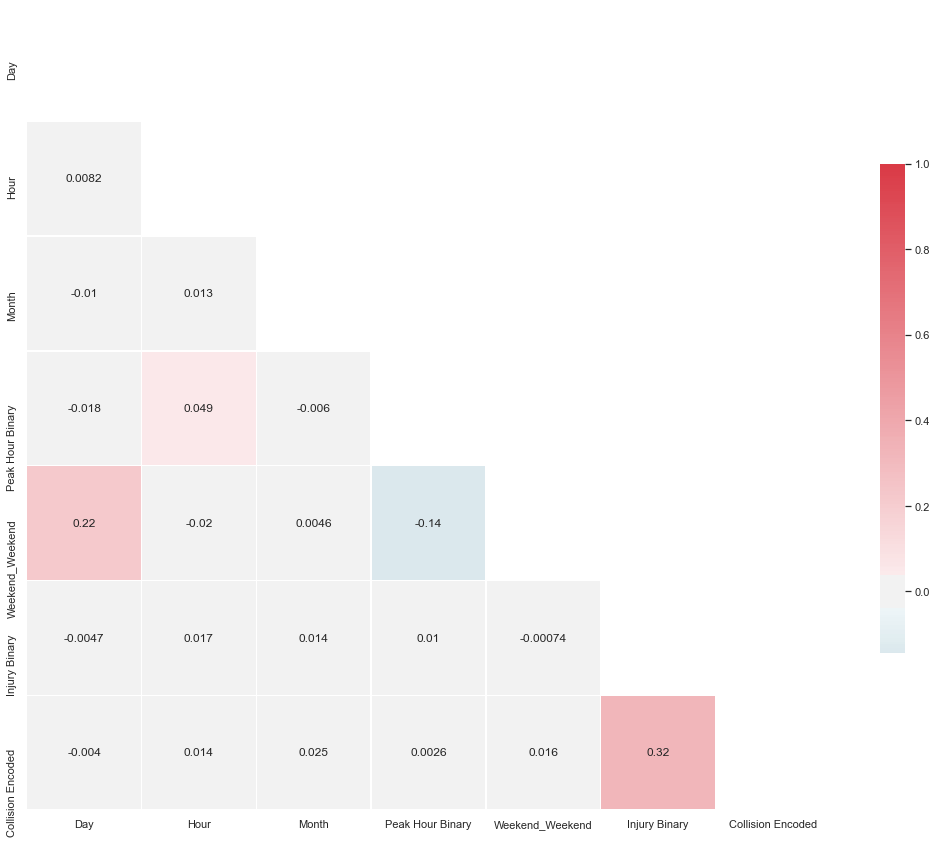

In [28]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(NYtraffic_binary.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(NYtraffic_binary.corr(), mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show();

# Start training, using Injury Binary as target variable

In [32]:
target_col = NYtraffic_binary['Injury Binary']
feature_cols_all = NYtraffic_binary[['Month','Day','Weekend_Weekend','Peak Hour Binary','Collision Encoded']]
X_train, X_test, y_train, y_test = train_test_split(feature_cols_all, target_col, random_state = 1)

### Logistic Regression

In [33]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

for col in zip(X_train.columns, logreg.coef_[0]):
    print('{:<20s}  {:+.06f}'.format(col[0], col[1]))

Month                 +0.005022
Day                   +0.002050
Weekend_Weekend       -0.024072
Peak Hour Binary      +0.038648
Collision Encoded     +4.896057


In [34]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Accuracy is:  0.8024277628835269
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     10417
           1       0.84      0.15      0.25      3011

    accuracy                           0.80     13428
   macro avg       0.82      0.57      0.57     13428
weighted avg       0.81      0.80      0.74     13428



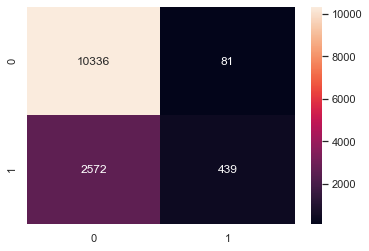

In [35]:
y_pred = logreg.predict(X_test)
ac = accuracy_score(y_test,y_pred)
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d");
print(classification_report(y_test, y_pred))

In [116]:
print('accuracy = {:7.4f}'.format(logreg.score(X_train, y_train)))
print('accuracy = {:7.4f}'.format(logreg.score(X_test, y_test)))

accuracy =  0.7958
accuracy =  0.8024


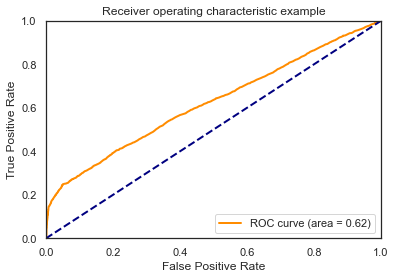

In [50]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

### Naive Bayes

Accuracy is:  0.7921507298182902
              precision    recall  f1-score   support

           0       0.81      0.95      0.88     10417
           1       0.59      0.25      0.35      3011

    accuracy                           0.79     13428
   macro avg       0.70      0.60      0.61     13428
weighted avg       0.76      0.79      0.76     13428



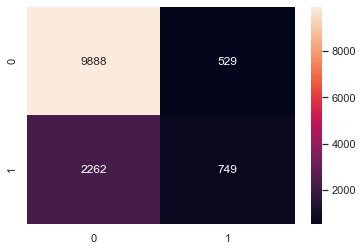

In [52]:
#Create a Gaussian Classifier
modelnb = GaussianNB()

# Train the model using the training sets 
modelnb.fit(X_train, y_train)

#Predict Score 
y_pred = modelnb.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d");
print(classification_report(y_test, y_pred))

In [53]:
print('accuracy = {:7.4f}'.format(modelnb.score(X_train, y_train)))
print('accuracy = {:7.4f}'.format(modelnb.score(X_test, y_test)))

accuracy =  0.7854
accuracy =  0.7922


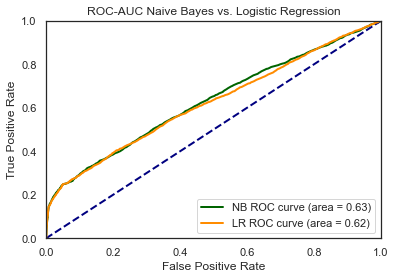

In [58]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
predsnb = modelnb.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fprnb, tprnb, _ = metrics.roc_curve(y_test, predsnb)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_aucnb = metrics.auc(fprnb, tprnb)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fprnb, tprnb, color='darkgreen', lw = lw, label = 'NB ROC curve (area = %0.2f)' % roc_aucnb)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'LR ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Naive Bayes vs. Logistic Regression')
plt.legend(loc = "lower right")
plt.show()

### Linear SVM

Accuracy is:  0.8024277628835269
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     10417
           1       0.84      0.15      0.25      3011

    accuracy                           0.80     13428
   macro avg       0.82      0.57      0.57     13428
weighted avg       0.81      0.80      0.74     13428



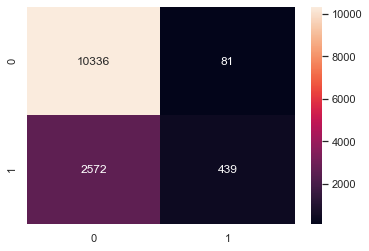

In [134]:
svc_model_linear = SVC(kernel='linear', probability=True)
svc_model_linear.fit(X_train, y_train)
svc_model_linear.score(X_test, y_test)

y_pred = svc_model_linear.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d");
print(classification_report(y_test, y_pred))

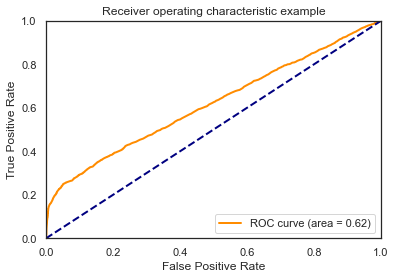

In [135]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = svc_model_linear.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

### Nonlinear SVM

Accuracy is:  0.7944593386952636
              precision    recall  f1-score   support

           0       0.79      0.99      0.88     10417
           1       0.84      0.10      0.18      3011

    accuracy                           0.79     13428
   macro avg       0.82      0.55      0.53     13428
weighted avg       0.80      0.79      0.73     13428



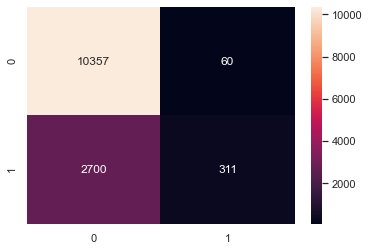

In [136]:
svc_model_poly = SVC(kernel='poly', probability=True)
svc_model_poly.fit(X_train, y_train)
svc_model_poly.score(X_test, y_test)

y_pred = svc_model_poly.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d");
print(classification_report(y_test, y_pred))

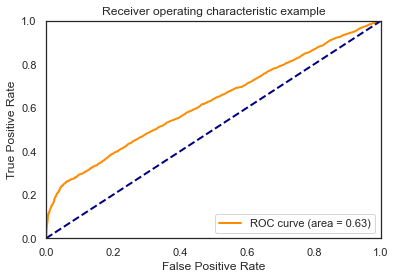

In [137]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = svc_model_poly.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

Accuracy is:  0.6540810247244564
              precision    recall  f1-score   support

           0       0.78      0.77      0.78     10417
           1       0.24      0.25      0.24      3011

    accuracy                           0.65     13428
   macro avg       0.51      0.51      0.51     13428
weighted avg       0.66      0.65      0.66     13428



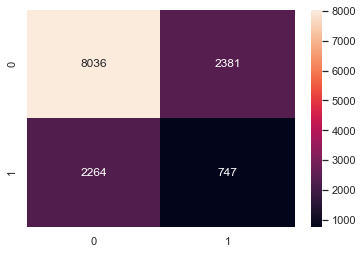

In [130]:
svc_model = SVC(kernel='sigmoid', probability=True)
svc_model.fit(X_train, y_train)
svc_model.score(X_test, y_test)

y_pred = svc_model.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d");
print(classification_report(y_test, y_pred))

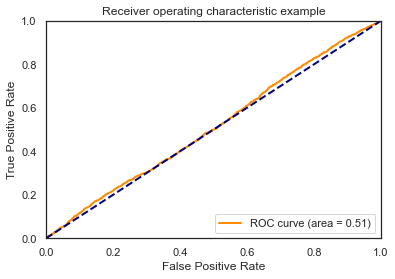

In [131]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = svc_model.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

### MLP - Multi-Layer Perceptron

Accuracy is:  0.8024277628835269
              precision    recall  f1-score   support

           0       0.79      0.99      0.88     10417
           1       0.84      0.10      0.18      3011

    accuracy                           0.79     13428
   macro avg       0.82      0.55      0.53     13428
weighted avg       0.80      0.79      0.73     13428



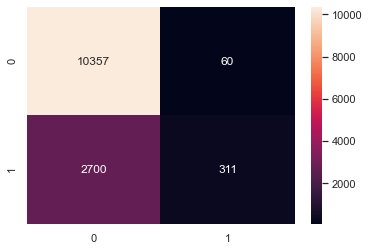

In [138]:
from sklearn.neural_network import MLPClassifier

#define the MLP model
mlp_model = MLPClassifier()

mlp_model.fit(X_train, y_train)

y_mlp_pred = mlp_model.predict(X_test)
ac = accuracy_score(y_test, y_mlp_pred)
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d");
print(classification_report(y_test, y_pred))

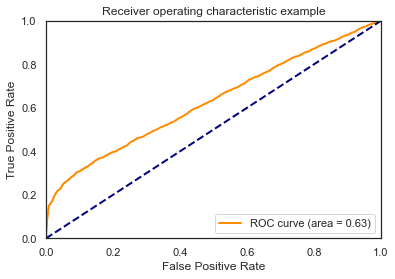

In [139]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = mlp_model.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

In [141]:
# Out of all these, Naive Bayes is the best predictor, as the FP is the lowest


#### From all this, it seems the model can predict with a fair amount of accuracy whether injuries will occur in a particular month, day, peak hour mixture. This however comes at a cost of having about 25% False Negatives, meaning it will predict there won't be a crash when there actually is one. There will be better models than this, absolutely, but this can be used as a guide.

In [152]:
target_col = NYtraffic_binary['Injury Binary']
feature_cols_all3 = NYtraffic_binary['Peak Hour Binary'].values.reshape(-1,1)
X_train3, X_test3, y_train3, y_test3 = train_test_split(feature_cols_all, target_col, random_state = 1)

Accuracy is:  0.8024277628835269
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     10417
           1       0.84      0.15      0.25      3011

    accuracy                           0.80     13428
   macro avg       0.82      0.57      0.57     13428
weighted avg       0.81      0.80      0.74     13428



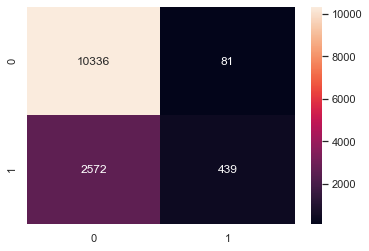

In [155]:
logreghour = LogisticRegression()
logreghour.fit(X_train3, y_train3)

y_pred3 = logreghour.predict(X_test)
ac = accuracy_score(y_test3,y_pred3)
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test3, y_pred3)
sns.heatmap(cm,annot=True,fmt="d");
print(classification_report(y_test3, y_pred3))

In [ ]:
# Create a DF for visually representing model scores

# data = {'Model': ['Logistic Regression','Naive Bayes','SVM-Poly'], 'Accuracy': [0.8024, 0.792, 0.794], 'Precision': [0.84,]}

# modelscores = 